In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df_train = pd.read_csv(r'C:\Users\casocha\Desktop\music/train.csv')
df_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1.0


In [3]:
df_song = pd.read_csv(r'C:\Users\casocha\Desktop\music/songs.csv')
df_song.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [4]:
df_mems = pd.read_csv(r'C:\Users\casocha\Desktop\music/members.csv')
df_mems.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
df_test = pd.read_csv(r'C:\Users\casocha\Desktop\music/test.csv')
df_test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [6]:
print(len(df_train),len(df_song),len(df_mems))

4211171 2296320 34403


In [7]:
df_mems['registration_year'] = df_mems['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
df_mems['registration_month'] = df_mems['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
df_mems['registration_date'] = df_mems['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

df_mems['expiration_year'] = df_mems['expiration_date'].apply(lambda x: int(str(x)[0:4]))
df_mems['expiration_month'] = df_mems['expiration_date'].apply(lambda x: int(str(x)[4:6]))
df_mems['expiration_date'] = df_mems['expiration_date'].apply(lambda x: int(str(x)[6:8]))
df_mems = df_mems.drop(['registration_init_time', 'expiration_date'], axis=1)

In [8]:
df_train['source_system_tab'].unique()

array(['explore', 'my library', 'search', 'discover', nan, 'radio',
       'listen with', 'notification', 'settings'], dtype=object)

In [9]:
df_train['source_type'].unique()

array(['online-playlist', 'local-playlist', 'local-library',
       'top-hits-for-artist', 'album', nan, 'song-based-playlist',
       'radio', 'song', 'listen-with', 'artist', 'topic-article-playlist'],
      dtype=object)

In [10]:
df_train['source_screen_name'].unique()

array(['Explore', 'Local playlist more', nan, 'My library',
       'Online playlist more', 'Album more', 'Discover Feature',
       'Unknown', 'Discover Chart', 'Radio', 'Artist more', 'Search',
       'Others profile more', 'Search Trends', 'Discover Genre',
       'My library_Search', 'Search Home', 'Discover New',
       'Self profile more', 'Concert', 'Payment'], dtype=object)

In [11]:
pal = 'husl'

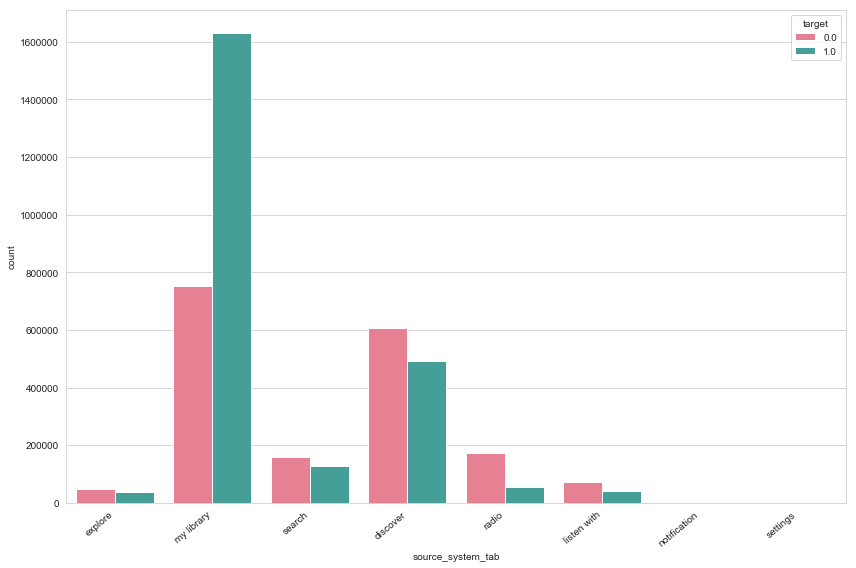

In [12]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))
sns.countplot(x="source_system_tab", data=df_train, palette=pal, hue='target')
axarr.set_xticklabels(axarr.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

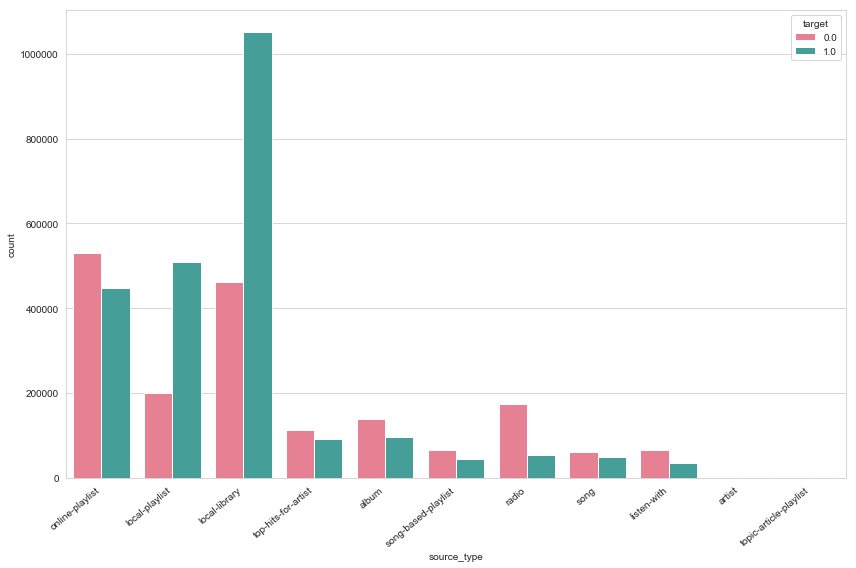

In [13]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))
sns.countplot(x="source_type", data=df_train, hue='target', palette=pal)
axarr.set_xticklabels(axarr.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.close(2)

In [14]:
df_train = pd.merge(left = df_train,right = df_mems,how='left',on='msno')
df_train = pd.merge(left = df_train,right = df_song,how = 'left',on='song_id')
df_train.fillna(-1,inplace=True)

In [15]:
df_test = pd.merge(left = df_test,right = df_mems,how='left',on='msno')
df_test = pd.merge(left = df_test,right = df_song,how = 'left',on='song_id')
df_test.fillna(-1,inplace=True)

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 21 columns):
id                    int64
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
city                  int64
bd                    int64
gender                object
registered_via        int64
registration_year     int64
registration_month    int64
registration_date     int64
expiration_year       int64
expiration_month      int64
song_length           float64
genre_ids             object
artist_name           object
composer              object
lyricist              object
language              float64
dtypes: float64(2), int64(9), object(10)
memory usage: 429.1+ MB


Text(0.5,1,'Heatmap of Attribute Correlation with Survived')

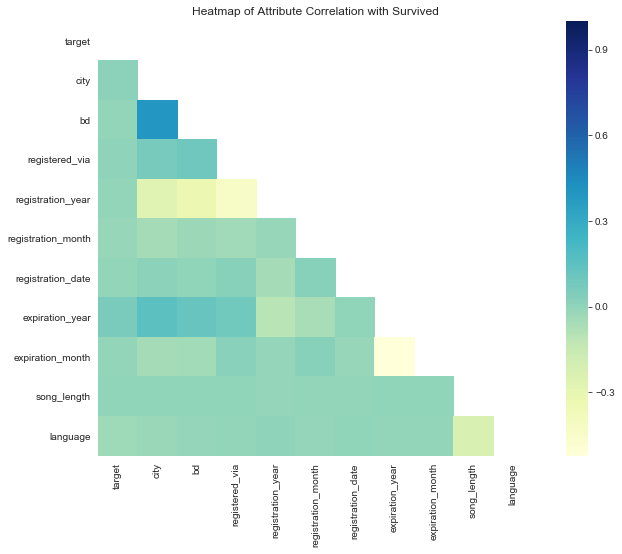

In [17]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))

cor = df_train.corr() #Calculate the correlation of the above variables
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor, mask = mask,square = True, cmap="YlGnBu") #Plot the correlation as heat map
plt.title('Heatmap of Attribute Correlation with Survived')

Text(0.5,1,'Age distribution')

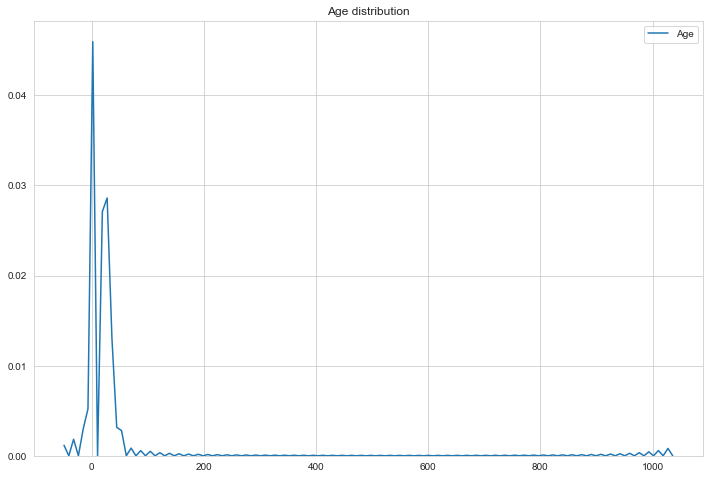

In [18]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(df_train.loc[:,'bd'], bw=2, label='Age')
plt.title('Age distribution')

In [19]:
df_int = df_train[df_train['bd'] < 110 ]
print(len(df_test))

2556790


Text(0.5,1,'Age distribution without outliers')

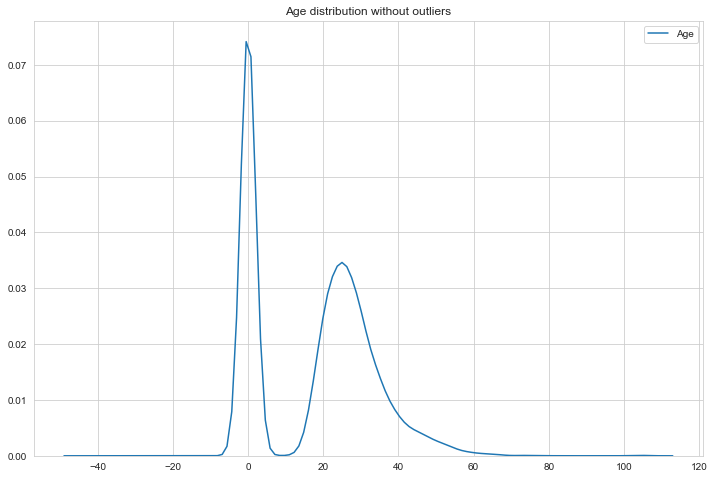

In [20]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(df_int.loc[:,'bd'], bw=2, label='Age')
plt.title('Age distribution without outliers')

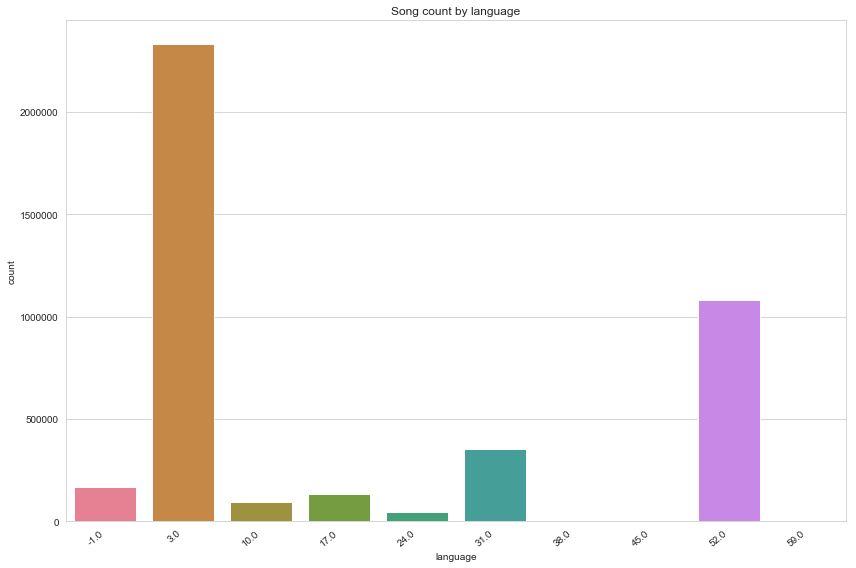

In [21]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))
sns.countplot(x="language", data=df_train,  palette=pal)
axarr.set_xticklabels(axarr.get_xticklabels(), rotation=40, ha="right")
plt.title('Song count by language')
plt.tight_layout()
plt.close(2)

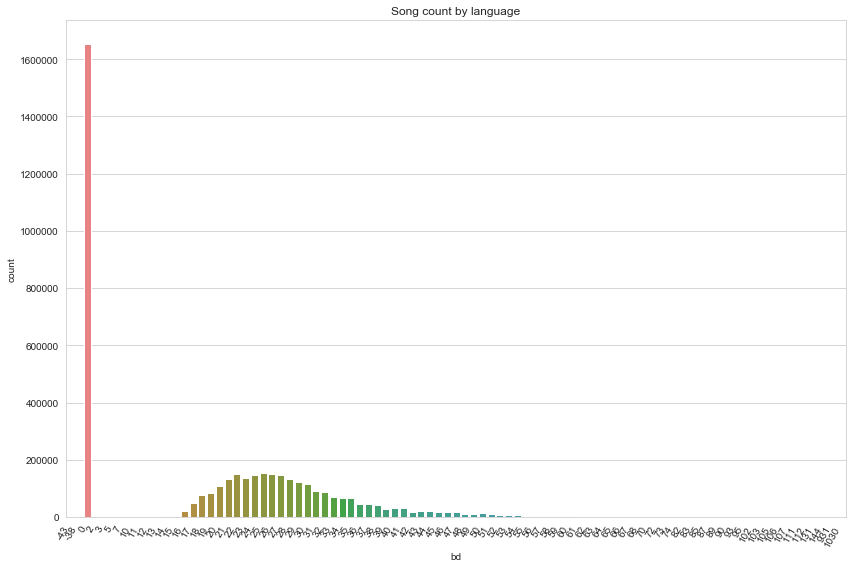

In [22]:
fig, axarr = plt.subplots(1, 1, figsize=(12, 8))
sns.countplot(x="bd", data=df_train,  palette=pal)
axarr.set_xticklabels(axarr.get_xticklabels(), rotation=60, ha="right")
plt.title('Song count by language')
plt.tight_layout()
plt.close(2)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [24]:
cols = list(df_train.columns)
cols.remove('target')

for col in cols:
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].apply(str)
        df_test[col] = df_test[col].apply(str)

        le = LabelEncoder()
        train_vals = list(df_train[col].unique())
        test_vals = list(df_test[col].unique())
        le.fit(train_vals + test_vals)
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

        print(col + ': ' + str(len(train_vals)) + ', ' + str(len(test_vals)))

print(df_train.head())
print(df_test.head())

out_test = np.array(df_test.drop(['id'], axis=1))
ids = df_test['id'].values


msno: 25097, 25131
song_id: 265115, 224753
source_system_tab: 9, 9
source_screen_name: 21, 23
source_type: 12, 13
gender: 3, 3
genre_ids: 511, 502
artist_name: 31063, 27564
composer: 59434, 52307
lyricist: 27375, 24911
    msno  song_id  source_system_tab  source_screen_name  source_type  target  \
0   8307    71688                  2                   8            7     1.0   
1  17420   215072                  4                   9            5     1.0   
2  17420   116222                  4                   9            5     1.0   
3  17420    22646                  4                   9            5     1.0   
4   8307    31752                  2                   8            7     1.0   

   city  bd  gender  registered_via    ...     registration_month  \
0     1   0       0               7    ...                      1   
1    13  24       1               9    ...                      5   
2    13  24       1               9    ...                      5   
3    13  24       

### XGBoost

In [42]:
X_train = np.array(df_train.drop(['target'], axis=1))
y_train = df_train['target'].replace(-1,0).values

X_test = np.array(df_test.drop(['id'], axis=1))
ids = df_test['id'].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [43]:
import xgboost as xgb

In [44]:
train_dmat = xgb.DMatrix(data=X_train, label=y_train)

In [29]:
dtest = xgb.DMatrix(X_valid,y_valid)

In [30]:
final_test = xgb.DMatrix(out_test)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gbm_param_grid = {
    'colsample_bytree': [0.3,.5,.2],
    'n_estimators': [10,50,100],
    'max_depth': [4,10],
    'learning_rate': [0.1],
    'objective': ['binary:logistic'],
    'gamma': [0,1,10],
    'reg_alpha': [0,1,10]   
}

gbm = xgb.XGBClassifier(nthread=5, tree_method='gpu_hist')

grid_mse = GridSearchCV(param_grid=gbm_param_grid, estimator=gbm,cv=4,verbose=1, n_jobs=5)

grid_mse.fit(X_train,y_train)

print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [36]:
gbm_param_grid = {
    'n_estimators': np.arange(10,150),
    'max_depth': np.arange(2,14),
    'colsample_bytree': np.arange(0.1,.8),
    'max_depth': np.arange(4,12),
    'learning_rate': np.arange(.01,0.2),
    'objective': ['binary:logistic'],
    'gamma': [0,1,10],
    'reg_alpha': np.arange(0,2)
}

In [37]:
# Instantiate the regressor: gbm
gbm = xgb.XGBClassifier(nthread=5, tree_method='gpu_hist')

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions=gbm_param_grid,estimator=gbm,
                                    n_iter=5,cv=2,verbose=1,n_jobs=5 )


# Fit randomized_mse to the data
randomized_mse.fit(X_train,y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 2 folds for each of 5 candidates, totalling 10 fits


C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed: 56.3min finished


Best parameters found:  {'reg_alpha': 1, 'objective': 'binary:logistic', 'n_estimators': 118, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.1}
Lowest RMSE found:  0.7966536605876658


In [38]:
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'reg_alpha': 1, 'objective': 'binary:logistic', 'n_estimators': 118, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.1}
Lowest RMSE found:  0.7966536605876658


### Predict / Train

In [45]:
params = {"max_depth":7}
params['silent'] = 1
params['eval_metric'] = 'auc'
params['tree_method'] = 'gpu_hist'
params['objective'] =  "binary:logistic"
params['n_estimators'] =  110
params['eta'] =  0.01
params['colsample_bytree'] =  0.1
params['gamma'] =  1
model = xgb.train(params=params, dtrain=train_dmat, maximize=True, verbose_eval=5)

In [53]:
p_test = model.predict(final_test)


# Prepare submission
print(len(ids), len(p_test))
subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test

2556790 2556790


In [51]:
subm.to_csv(r'submission.csv', index=False)

In [48]:
len(subm)

2556790

In [56]:
y_preds = model.predict(dtest)

In [57]:
# make predictions for test data and evaluate
from sklearn.metrics import roc_auc_score

predictions = [round(value) for value in y_preds]
accuracy = roc_auc_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.19%


In [58]:
X_train = pd.DataFrame(X_train)
X_train=X_train.fillna(-1)
np.isnan(X_train).any()
X_valid = pd.DataFrame(X_valid)
X_valid=X_valid.fillna(-1)
np.isnan(X_valid).any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
dtype: bool

In [59]:
from numpy import loadtxt
from numpy import sort
from sklearn.feature_selection import SelectFromModel
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
X_train = pd.DataFrame(X_train)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()#params=params
    selection_model.fit(X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_valid)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, X_train.shape[1], accuracy*100.0))

AttributeError: 'Booster' object has no attribute 'feature_importances_'

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance
plot_importance(model)
pyplot.show()